In [237]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import signal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from loess.loess_1d import loess_1d
from statsmodels.nonparametric.smoothers_lowess import lowess
from tvregdiff import TVRegDiff
import pandas as pd
from scipy.optimize import curve_fit

In [238]:
def create_exp(N, A, B):
    expo = A*np.exp(-B*np.arange(0,N))
    return expo
def create_lin(N, a, b):
    lin = a*np.arange(0,N) + b
    return lin
def concat_noise(C, m = 0, s = 1):
    # import numpy as np
    concat = []
    for c in C:
        concat.extend(c)
    X = np.arange(0,len(concat))
    Y = concat +  np.random.normal(loc=m, scale=s, size=len(concat))
    return X, Y

def RMSE(Ypred, Yreal):
    rmse = np.sqrt(np.sum(np.square(Ypred-Yreal))/np.shape(Ypred)[0])
    return rmse
def fit_and_pred(X, y):
    Xarr = np.array(X).reshape(-1,1)
    yarr = np.array(y).reshape(-1,1)
    reg = LinearRegression().fit(Xarr, yarr)
    pred = reg.predict(Xarr)
    rmse = RMSE(pred, yarr)
    return rmse
def sliding_window_pred(X, y, window, lag):
    Xmax = np.shape(X)[0]-window+1
    start = np.arange(0, Xmax, lag)
    mean_start = X[[int(s + window/2) for s in start]]
    score = [fit_and_pred(X[s:s+window], y[s:s+window]) 
            for s in start]    
    return score, mean_start

# def func(x, a, b):
#     return a * np.exp(-b * x) + c
def func(x, a, b):
    return a * np.exp(-b * x) 

def fit_and_pred_exp(X, y, b, p):
    Xarr = np.array(X).reshape(-1)
    yarr = np.array(y).reshape(-1)
    reg = curve_fit(func, Xarr, yarr, bounds=b)[0]
#     A, B, C = reg
    A, B = reg
    if p:
        print('fit: a=%5.3f, b=%5.6f' % tuple(reg))
#     print('fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(reg))
    pred = A * np.exp(-B * Xarr) #+ C
    rmse = RMSE(pred, yarr)
    return rmse

def sliding_window_exp_pred(X, y, window, lag, b=([9,  0.00001], [11.,  0.001]), p = False):
    Xmax = np.shape(X)[0]-window+1
    start = np.arange(0, Xmax, lag)
    mean_start = X[[int(s + window/2) for s in start]]
    score = [fit_and_pred_exp(X[s:s+window], y[s:s+window], b=b, p = p) 
            for s in start]    
    return score, mean_start


def dcross(Yl, Ye):
    idx = np.argwhere(np.diff(np.sign(Yl - Ye))).flatten() 
    return idx

def detect_crossing(Yexp, Ylin, X , plot = False):
    Ylin=np.array(Ylin)
    Yexp=np.array(Yexp)
    X=np.array(X)    
    idx = dcross(Ylin, Yexp)
    Xidx=X[idx]
    Yidx=Ylin[idx]
    
    if plot:
        plt.plot(X, Ylin)
        plt.plot(X, Yexp)
        plt.plot(Xidx, Yidx, 'ro')
        plt.show()
        
        print('\nShifting point method')
        print('detected changes at time : {}'.format(Xidx))
        
    return idx, Xidx


def detect_crossing_int(Yexp, Ylin, X , plot = False):
    Ylin=np.array(Ylin)
    Yexp=np.array(Yexp)
    X=np.array(X)  
    
    idx = dcross(Ylin, Yexp)
    Xidx=X[idx]    
    idx_int = [[i, i+1] for i in idx]
    Xidx_int = [[X[i], X[i+1] ]for i in idx]
    Yidx=Ylin[idx]

    if plot:
        plt.plot(X, Ylin)
        plt.plot(X, Yexp)
        
        for i in np.arange(0,len(idx)):
            plt.hlines(Yidx[i], Xidx_int[i][0], Xidx_int[i][1], lw=4, color = 'red')
        plt.show()     
        
        print('\nInterval method')
        for i in np.arange(0,len(idx)):
            print('detected changes between times : {} - {}'.format(Xidx_int[i][0], Xidx_int[i][1]))
        
    return idx, Xidx, Xidx_int


# Few tests

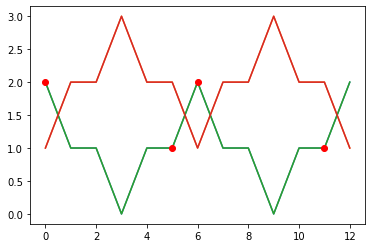


Shifting point method
detected changes at time : [ 0  5  6 11]


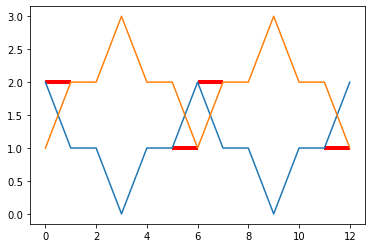


Interval method
detected changes between times : 0 - 1
detected changes between times : 5 - 6
detected changes between times : 6 - 7
detected changes between times : 11 - 12


(array([ 0,  5,  6, 11]),
 array([ 0,  5,  6, 11]),
 [[0, 1], [5, 6], [6, 7], [11, 12]])

In [239]:
a = np.array([2,1,1,0,1,1,2,1,1,0,1,1,2])
b = np.array([0,1,1,2,1,1,0,1,1,2,1,1,0])+1

plt.plot(a)
plt.plot(b)

detect_crossing(Ylin=a, Yexp=b, X=np.arange(0,len(a)), plot = True)
detect_crossing_int(Ylin=a, Yexp=b, X=np.arange(0,len(a)), plot = True)

60
60
60


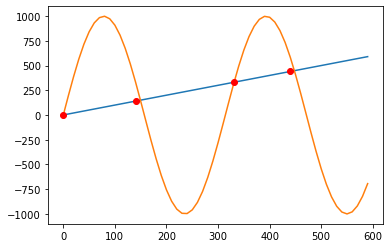

detected changes at time : [  0 140 330 440]


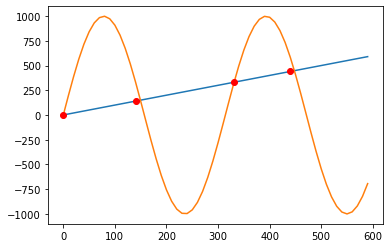


Shifting point method
detected changes at time : [  0 140 330 440]


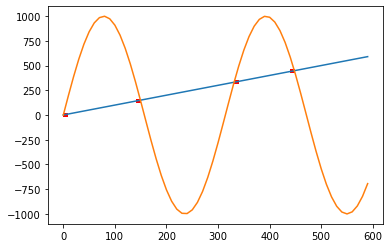


Interval method
detected changes between times : 0 - 10
detected changes between times : 140 - 150
detected changes between times : 330 - 340
detected changes between times : 440 - 450


(array([ 0, 14, 33, 44]),
 array([  0, 140, 330, 440]),
 [[0, 10], [140, 150], [330, 340], [440, 450]])

In [240]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 600, 10); print(x.shape[0])
f = np.arange(1, 600+1, 10); print(f.shape[0])
g = np.sin(np.arange(0, 6, 0.1) * 2) * 1000; print(g.shape[0])

plt.plot(x, f, '-')
plt.plot(x, g, '-')

idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
plt.plot(x[idx], f[idx], 'ro')
plt.show()
print('detected changes at time : {}'.format(x[idx]))

detect_crossing(Ylin=f, Yexp=g, X=x , plot = True)
detect_crossing_int(Ylin=f, Yexp=g, X=x , plot = True)

# Simulated data

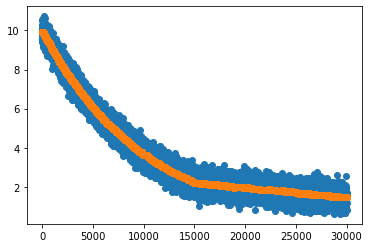

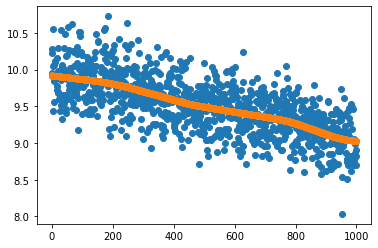

In [241]:
expo = create_exp(N = 15000, A = 10 , B = 0.0001)
lin = create_lin(N = 15000, a = -0.00005 , b = expo[-1]-0.01*expo[-1])

X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.3)
Ysmooth = lowess(exog = X, endog = Y, frac = 0.01, delta = 0.001 * X.shape[0], return_sorted = False)

plt.scatter(X,Y)
plt.scatter(X,Ysmooth)
plt.show()

plt.scatter(X[0:1000],Y[0:1000])
plt.scatter(X[0:1000],Ysmooth[0:1000])
plt.show()

## linear RMSE

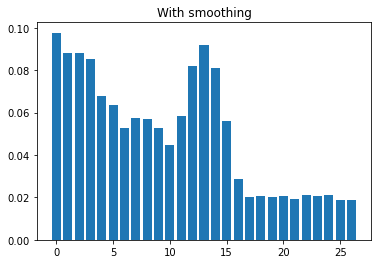

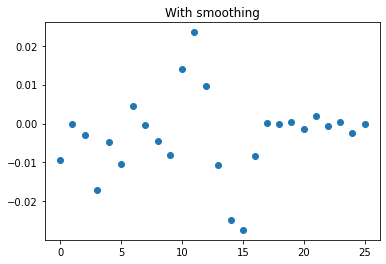

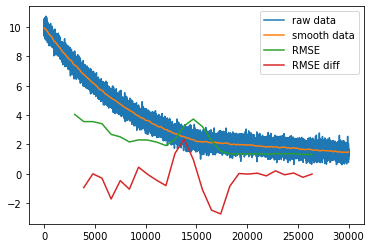

In [242]:
score,Xscore  = sliding_window_pred(X = X, y = Ysmooth, 
                            window = 6000, 
                            lag = 900)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('With smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('With smoothing')
plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(1+np.array(score))**15, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*100, label = 'RMSE diff')
plt.legend()
plt.show()

## Exponential RMSE

b is a bound parameters for A and B parameters of the exponential function 

this setting can deeply influence non linear regression

In [1]:
score,Xscore  = sliding_window_exp_pred(X = X, y = Ysmooth, 
                            window = 5000, 
                            lag = 500, b=([9,  0.00001], [11.,  0.001]), p =True)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('With smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('With smoothing')
plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(1+np.array(score))**5, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*100, label = 'RMSE diff')
plt.legend()
plt.show()

NameError: name 'sliding_window_exp_pred' is not defined

## Both linear and exp RMSE

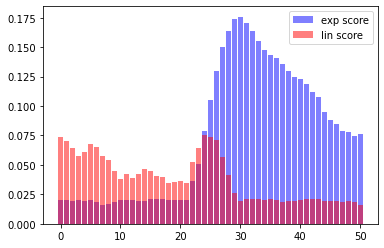

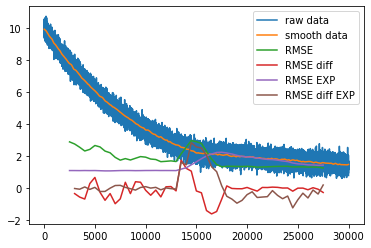

In [244]:
score,Xscore  = sliding_window_pred(X = X, y = Ysmooth, 
                            window = 5000, 
                            lag = 500)

score_exp,Xscore_exp  = sliding_window_exp_pred(X = X, y = Ysmooth, 
                            window = 5000, 
                            lag = 500, b=([9,  0.00001], [11.,  0.001]), p = False)


plt.bar(np.arange(0,len(score_exp)),score_exp, label = 'exp score', fc=(0, 0, 1, 0.5))
plt.bar(np.arange(0,len(score)),score, label = 'lin score', fc=(1, 0, 0, 0.5))
plt.legend()
plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(1+np.array(score))**15, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*100, label = 'RMSE diff')

plt.plot(Xscore_exp,(1+np.array(score_exp))**5, label = 'RMSE EXP') # amplified in order to have similar scale with raw signal
plt.plot(Xscore_exp[1:],np.diff(score_exp)*100, label = 'RMSE diff EXP')
plt.legend()
plt.show()

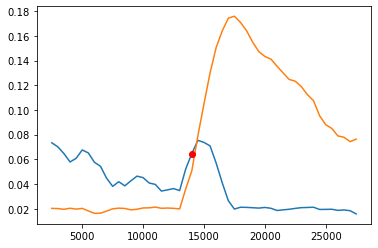


Shifting point method
detected changes at time : [14000]


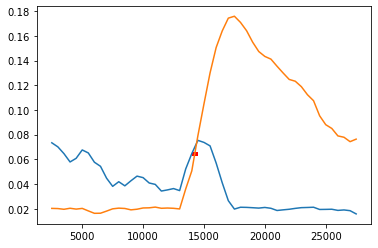


Interval method
detected changes between times : 14000 - 14500


(array([23]), array([14000]), [[14000, 14500]])

In [245]:

detect_crossing(Ylin=score, Yexp=score_exp, X=Xscore , plot = True)
detect_crossing_int(Ylin=score, Yexp=score_exp, X=Xscore , plot = True)

This is super nice :)

# Real data

['LituBD5_mass', 'LituLD2_mass', 'LituBL2t_mass', 'LituLL21_mass']


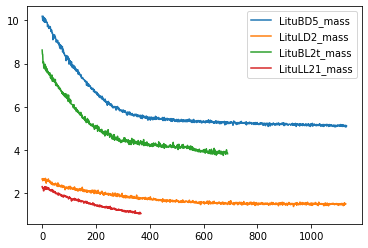

In [246]:
df = pd.read_csv('/home/xavier/Documents/development/time series_dehydration.csv', sep = ",")
df.head()
col = [c for c in df.columns if c != 'time_min']
print(col)
df[col].plot()

test for LituBD5_mass -------------------------------
fit: a=10.218, b=0.000540
fit: a=10.156, b=0.000525
fit: a=10.041, b=0.000503
fit: a=9.869, b=0.000475
fit: a=9.635, b=0.000441
fit: a=9.340, b=0.000402
fit: a=8.991, b=0.000360
fit: a=8.601, b=0.000316
fit: a=8.185, b=0.000270
fit: a=8.041, b=0.000254
fit: a=8.041, b=0.000250
fit: a=8.041, b=0.000245
fit: a=8.041, b=0.000239
fit: a=8.041, b=0.000232
fit: a=8.041, b=0.000225
fit: a=8.041, b=0.000218
fit: a=8.041, b=0.000211
fit: a=8.041, b=0.000203
fit: a=8.041, b=0.000197
fit: a=8.041, b=0.000190
fit: a=8.041, b=0.000184
fit: a=8.041, b=0.000178
fit: a=8.041, b=0.000173
fit: a=8.041, b=0.000168
fit: a=8.041, b=0.000163
fit: a=8.041, b=0.000158
fit: a=8.041, b=0.000154
fit: a=8.041, b=0.000150
fit: a=8.041, b=0.000146
fit: a=8.041, b=0.000142
fit: a=8.041, b=0.000139
fit: a=8.041, b=0.000135
fit: a=8.041, b=0.000132
fit: a=8.041, b=0.000129
fit: a=8.041, b=0.000126
fit: a=8.041, b=0.000124
fit: a=8.041, b=0.000121
fit: a=8.041, b=0.

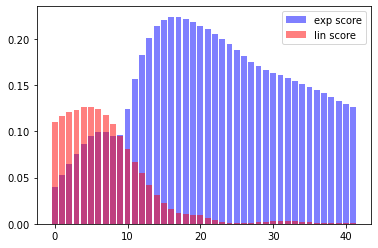

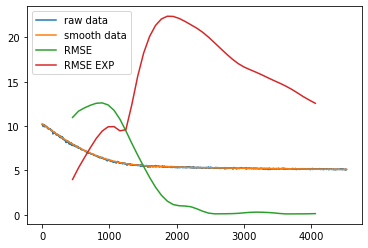

test for LituLD2_mass -------------------------------
fit: a=2.593, b=0.000321
fit: a=2.550, b=0.000289
fit: a=2.508, b=0.000262
fit: a=2.477, b=0.000245
fit: a=2.456, b=0.000235
fit: a=2.443, b=0.000229
fit: a=2.434, b=0.000225
fit: a=2.423, b=0.000220
fit: a=2.405, b=0.000213
fit: a=2.383, b=0.000205
fit: a=2.358, b=0.000196
fit: a=2.330, b=0.000188
fit: a=2.302, b=0.000179
fit: a=2.271, b=0.000170
fit: a=2.237, b=0.000161
fit: a=2.203, b=0.000152
fit: a=2.169, b=0.000144
fit: a=2.132, b=0.000134
fit: a=2.087, b=0.000124
fit: a=2.038, b=0.000112
fit: a=1.992, b=0.000102
fit: a=1.951, b=0.000092
fit: a=1.908, b=0.000083
fit: a=1.862, b=0.000073
fit: a=1.815, b=0.000062
fit: a=1.769, b=0.000053
fit: a=1.730, b=0.000044
fit: a=1.698, b=0.000038
fit: a=1.671, b=0.000032
fit: a=1.646, b=0.000027
fit: a=1.640, b=0.000026
fit: a=1.641, b=0.000026
fit: a=1.642, b=0.000026
fit: a=1.643, b=0.000026
fit: a=1.645, b=0.000026
fit: a=1.647, b=0.000026
fit: a=1.650, b=0.000026
fit: a=1.652, b=0.000

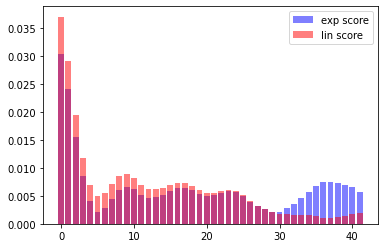

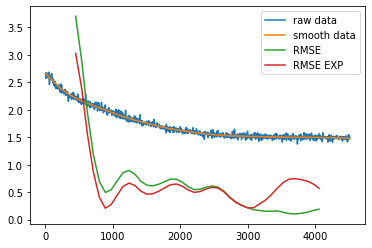

test for LituBL2t_mass -------------------------------
fit: a=8.058, b=0.000625
fit: a=8.049, b=0.000622
fit: a=8.037, b=0.000618
fit: a=8.024, b=0.000613
fit: a=7.994, b=0.000603
fit: a=7.936, b=0.000587
fit: a=7.845, b=0.000564
fit: a=7.714, b=0.000535
fit: a=7.542, b=0.000500
fit: a=7.346, b=0.000463
fit: a=7.151, b=0.000428
fit: a=6.973, b=0.000398
fit: a=6.809, b=0.000371
fit: a=6.648, b=0.000345
fit: a=6.476, b=0.000317
fit: a=6.278, b=0.000286
fit: a=6.062, b=0.000253
fit: a=6.037, b=0.000248
fit: a=6.037, b=0.000246
fit: a=6.037, b=0.000244
fit: a=6.037, b=0.000240
fit: a=6.037, b=0.000237
fit: a=6.037, b=0.000232
fit: a=6.037, b=0.000228
fit: a=6.037, b=0.000223
fit: a=6.037, b=0.000219
fit: a=6.037, b=0.000215
fit: a=6.037, b=0.000211
fit: a=6.037, b=0.000207
fit: a=6.037, b=0.000203
fit: a=6.037, b=0.000199
fit: a=6.037, b=0.000196
fit: a=6.037, b=0.000192
fit: a=6.037, b=0.000189
fit: a=6.037, b=0.000186
fit: a=6.037, b=0.000184
fit: a=6.037, b=0.000182
fit: a=6.037, b=0.00

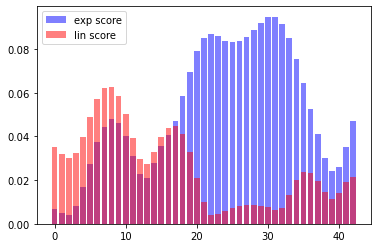

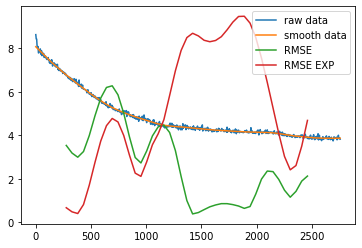

test for LituLL21_mass -------------------------------
fit: a=2.292, b=0.000638
fit: a=2.306, b=0.000670
fit: a=2.314, b=0.000681
fit: a=2.311, b=0.000671
fit: a=2.300, b=0.000651
fit: a=2.287, b=0.000631
fit: a=2.276, b=0.000616
fit: a=2.265, b=0.000602
fit: a=2.252, b=0.000584
fit: a=2.236, b=0.000565
fit: a=2.220, b=0.000546
fit: a=2.204, b=0.000529
fit: a=2.188, b=0.000514
fit: a=2.171, b=0.000499
fit: a=2.159, b=0.000490
fit: a=2.159, b=0.000492
fit: a=2.176, b=0.000505
fit: a=2.199, b=0.000523
fit: a=2.219, b=0.000537
fit: a=2.233, b=0.000545
fit: a=2.239, b=0.000549
fit: a=2.232, b=0.000544
fit: a=2.220, b=0.000537
fit: a=2.204, b=0.000527
fit: a=2.185, b=0.000517
fit: a=2.168, b=0.000507
fit: a=2.159, b=0.000502
fit: a=2.149, b=0.000498
fit: a=2.143, b=0.000494
fit: a=2.146, b=0.000496
fit: a=2.156, b=0.000501
fit: a=2.157, b=0.000502
fit: a=2.156, b=0.000501
fit: a=2.162, b=0.000503
fit: a=2.167, b=0.000505
fit: a=2.148, b=0.000497
fit: a=2.103, b=0.000478
fit: a=2.043, b=0.00

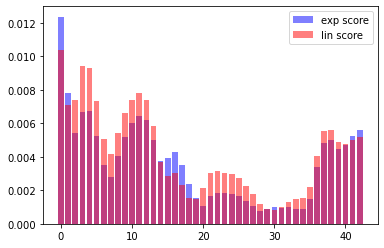

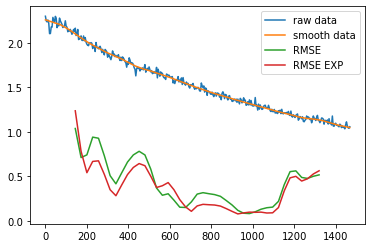

In [247]:
#extracted from third iteration and then refitted can be automatized later

Bound = [([10.041-2,0.0000503],[10.041+2,0.00503]), #a=5.504, b=0.000016
         ([2.508-2,0.0000262],[2.508+2,0.00262]), #  a=2.000, b=0.000072
         ([8.037-2,0.0000618],[8.037+2,0.00618]), #a=5.119, b=0.000107
         ([2.314-2,0.0000681],[2.314+2,0.00681])] #a=2.000, b=0.000436

i = 0
for c in col:
    
    print('test for {} -------------------------------'.format(c))
    df2 = df[['time_min', c]].dropna(subset = [c])
    Ysmooth = lowess(exog = df2['time_min'].values, endog = df2[c].values, frac = 0.1, delta = 0.1 * df2['time_min'].shape[0], return_sorted = False)
    
    
    score,Xscore  = sliding_window_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50))

    score_exp,Xscore_exp  = sliding_window_exp_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50), b= Bound[i], p = True)
    i+=1
    plt.bar(np.arange(0,len(score_exp)),score_exp, label = 'exp score', fc=(0, 0, 1, 0.5))
    plt.bar(np.arange(0,len(score)),score, label = 'lin score', fc=(1, 0, 0, 0.5))
    plt.legend()
    plt.show()

    plt.plot(df2['time_min'].values,df2[c].values, label = 'raw data')
    plt.plot(df2['time_min'].values, Ysmooth, label = 'smooth data')
    plt.plot(Xscore,np.array(score)*100, label = 'RMSE') # amplified in order to have similar scale with raw signal
#     plt.plot(Xscore[1:],np.diff(score), label = 'RMSE diff')

    plt.plot(Xscore_exp,np.array(score_exp)*100, label = 'RMSE EXP') # amplified in order to have similar scale with raw signal
#     plt.plot(Xscore_exp[1:],np.diff(score_exp), label = 'RMSE diff EXP')
    plt.legend()
    plt.show()


test for LituBD5_mass -------------------------------


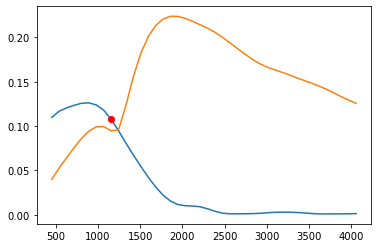


Shifting point method
detected changes at time : [1156]


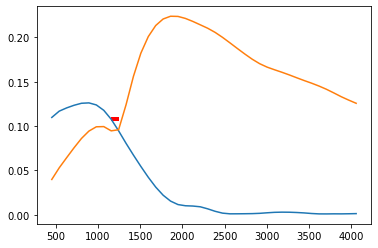


Interval method
detected changes between times : 1156 - 1244

test for LituLD2_mass -------------------------------


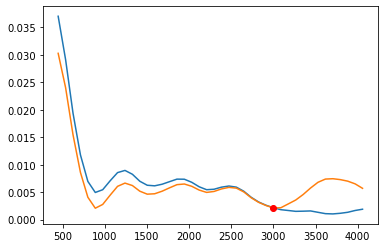


Shifting point method
detected changes at time : [3000]


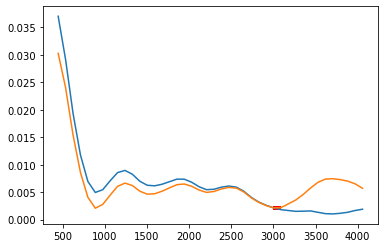


Interval method
detected changes between times : 3000 - 3088

test for LituBL2t_mass -------------------------------


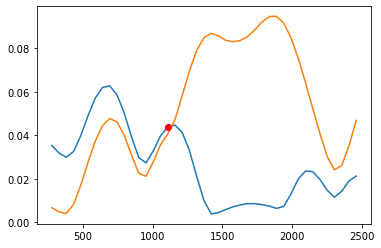


Shifting point method
detected changes at time : [1108]


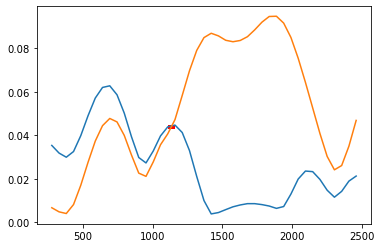


Interval method
detected changes between times : 1108 - 1160

test for LituLL21_mass -------------------------------


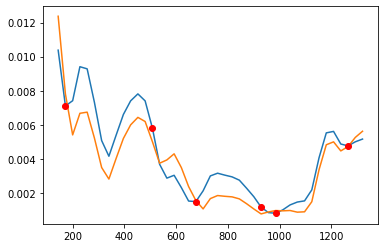


Shifting point method
detected changes at time : [ 172  508  676  928  984 1264]


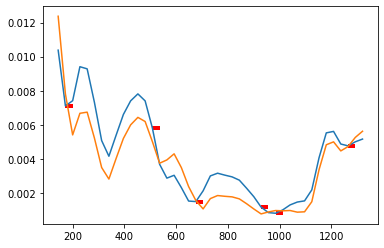


Interval method
detected changes between times : 172 - 200
detected changes between times : 508 - 536
detected changes between times : 676 - 704
detected changes between times : 928 - 956
detected changes between times : 984 - 1012
detected changes between times : 1264 - 1292


In [249]:
#extracted from third iteration and then refitted can be automatized later

Bound = [([10.041-2,0.0000503],[10.041+2,0.00503]), #a=5.504, b=0.000016
         ([2.508-2,0.0000262],[2.508+2,0.00262]), #  a=2.000, b=0.000072
         ([8.037-2,0.0000618],[8.037+2,0.00618]), #a=5.119, b=0.000107
         ([2.314-2,0.0000681],[2.314+2,0.00681])] #a=2.000, b=0.000436

i = 0
for c in col:
    
    print('\ntest for {} -------------------------------'.format(c))
    df2 = df[['time_min', c]].dropna(subset = [c])
    Ysmooth = lowess(exog = df2['time_min'].values, endog = df2[c].values, frac = 0.1, delta = 0.1 * df2['time_min'].shape[0], return_sorted = False)
    
    
    score,Xscore  = sliding_window_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50))

    score_exp,Xscore_exp  = sliding_window_exp_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50), b= Bound[i], p = False)
    i+=1
    idx, xidx = detect_crossing(Ylin=score, Yexp=score_exp, X=Xscore , plot = True)
    idx, xidx, xidx_int = detect_crossing_int(Ylin=score, Yexp=score_exp, X=Xscore , plot = True)    
    